In [2]:
# General Idea of Qubit Characterization

In [ ]:
## NOTEBOOK TO ANALYZE THE CAVITY COUPLED TO THE QUBIT. WE FIND THE OPTIMUM VALUES TO PLACE THE CAVITY SO WE CAN ANALYZE WHERE
## THE QUBIT IS. THE WAY WE DO THIS IS THE FOLLOWING.
## 1) Find Cavity by either doing a PNA scan through Jupyter or on the actual PNA
## 2) Once you have the cavity frequency, so a power scan to see the dependence. Should be able to resolve dressed and
## and bright state. This is also a major indicator that the qubit is alive.
## 3) Measure flux dependence. From the flux dependence should be able to resolve the voltage at which the Upper sweet
## spot (USS) and Lower sweet spot (LSS) is located. We normally try to bias at USS.
## 4) After tuning the flux and adjusting the power to be in the dressed state you need to find a refined cavity 
## frequency at these two points (USS and dressed state).
## 5) Move over to the Spectroscopy notebook in the Home folder. At this point you will try to find the qubit, seeing 
## if it tunes with flux.

## Troubleshooting:
## 1) If you can't see the qubit, make sure the power is low enough to see the qubit in the dressed state.
## We never do the bright state measurement on the ADR setup.
## 2) One can also use the LSS if you can't resolve the USS. Sometimes the cavity and the USS are too close to one
## making the flux tuning not obtainable.
## 3) ADR2 side A sometimes has issues with the noise floor making it hard to do measurements at times.

# Import modules. Run once

In [2]:
%matplotlib

# import system modules
import sys
import os.path
import matplotlib.pyplot as plt   
from IPython.display import clear_output
import numpy as np
import json
import visa
import time
from scipy import optimize
from math import pi

# Add path
#sys.path.remove(r'\\shared.ad.syr.edu\AS-Filer\PHY-PRL-labshare\Programs\python\Drivers')
sys.path.append(r'Z:\User\Jaseung\programs\pythonCode\Instrument Driver') # path added
#sys.path.append('..\Instrument Driver') # path added

sys.path.append('..\Helper') # path added

# custom modules
import myplots_py3, myutils # Jaseung's custom modules


Using matplotlib backend: Qt5Agg


# Set up devices to use. Modify and run once.

In [3]:
# instrument drivers
import SIM
import AgilentN5230A
import LSCI332S
import HittiteHMC
import AgilentMXG
import SynthHD
import Agilent33250A
import KeysightP9372A
import time

# instrument instances. Make device objects.

#pna = AgilentN5230A.AgilentN5230A(16) #For Regular PNA

pna = KeysightP9372A.KeysightP9372A('PXI10::0-0.0::INSTR') #Keysight P9372A
pna.connect()
#Vglb_init = SIM.SIM(15, channel = 2) #ADR2
#sim_2 = SIM.SIM(15, channel = 1) #ADR2
#sim_1 = SIM.SIM('COM7', channel = 1) #ADR1 - If using regular computer
#sim_2 = SIM.SIM('COM7', channel = 2) #ADR1

sim_1 = SIM.SIM('COM3', channel = 3) #ADR1 -If using mobile computer cart. Channel is which port the sim is plugged into.
#sim_2 = SIM.SIM('COM2', channel = 2) #ADR1

#spec = SynthHD.SynthHD(6) # for windfreak (SynthHD)
#spec.setChannel(0) # for SynthHD,0= channel A,1=channel B

#Tip on finding COM port: If you have trouble finding the COM port on windows: Start menu
#-> type "Device Manager" -> Look under "Ports" -> try unplugging and plug back
# in to see which COM port goes away

lsci = LSCI332S.LSCI332S(2)# - Not sure what this is for.
#spec = HittiteHMC.HittiteHMC('USB',4)
#spec = AgilentMXG.AgilentMXG(30)
# pump = SynthHD.SynthHD(18)


# fridge type.
fridgeType = 'ADR2'   # options: 'ADR2', 'BF', 'DR1', ADR1

In [4]:
pna.connect() #Need to do this for new PNA: P9372A

In [4]:
#spec.setRef(2) (For adjustment of code to allow for spectroscopy)
#spec.pwrOn()

# (Optional) List resources

In [5]:
# This is useful to check if GPIB or USB is valid.
import visa
rm = visa.ResourceManager()
rm.list_resources()

('ASRL1::INSTR',
 'ASRL3::INSTR',
 'ASRL10::INSTR',
 'GPIB0::1::INSTR',
 'GPIB0::2::INSTR',
 'GPIB0::3::INSTR',
 'GPIB0::10::INSTR',
 'GPIB0::15::INSTR',
 'PXI10::0-0.0::INSTR',
 'USB0::0x0699::0x0345::C021722::0::INSTR',
 'USB0::0x0957::0x179B::MY51361453::0::INSTR')

# S21 vs Freq, 1D, single scan

Initialized S21 Measurement 'S21Meas'
Measurement finished!!!


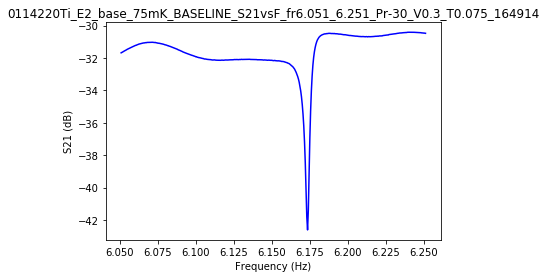

In [17]:
#################################################################################

# Last Updated: 2/27/20

#set up parameters
startFreq, endFreq = 6.051e9, 6.251e9
power = -30 #[dB]
numPoints, IFbandwidth, avg = 401, 10, 25
volt = 0.3

sampleID = '0114220Ti_E2_base_75mK_BASELINE'
suffix = ''
save_path = r'Z:\Experiments\Titanium\011420Ti\022020\E2\Temperature_sweep\2_27_20'
#save_path = r'C:\Users\Lab User\Desktop\Crap, please organize\SFQFlipIV\MCMunknown'
#save_path = r'Z:\User\Andrew\Fluxnoise_measurements\AB26_30_RRR\AB26'
#################################################################################

# dictionary for parameters to be saved in log file.
header = 'freq (Hz) mag(dB) phase(degree) real imag'
para = dict([('startFreq (Hz)',startFreq),('endFreq (Hz)', endFreq),('power (dBm)',power)
             ,('numPoints',numPoints), ('IFbandwidth (Hz)', IFbandwidth),('avg',avg)
             ,('volt',volt), ('header', header)])

# file setup
if fridgeType=='ADR2':
    FAA = float(lsci.tempGet('B')) # get temperature
else :
    FAA = 0 
timeStr = time.strftime("%H%M%S")
baseStr = sampleID + '_S21vsF_fr{:.9g}_{:.9g}_Pr{}_V{}_T{:.4g}_{}'
baseFileName = baseStr.format(startFreq/1e9, endFreq/1e9, power, volt, FAA, timeStr)
dataFileName = os.path.join(save_path, baseFileName + '.dat')                                 
logFileName =  os.path.join(save_path, baseFileName + '.json')

with open(logFileName, 'w') as f:
    json.dump(para,f,indent=4, sort_keys=True)

# plot setup
plotobj= myplots_py3.plot1D(ylabel = 'S21 (dB)', xlabel='Frequency (Hz)', title = baseFileName, plotStyle='b-')

# configure instrument
pna.setupMeas()
time.sleep(0.5)
pna.setSweepType('linear')
time.sleep(0.5)
pna.setFreqStartEnd(startFreq, endFreq)
time.sleep(0.5)
pna.setPwr(power)
time.sleep(0.5)
pna.avgCount(avg)
time.sleep(0.5)
pna.numPoints(numPoints)
time.sleep(0.5)
pna.setIF(IFbandwidth)
time.sleep(0.5)
pna.pwrOn()
time.sleep(0.5)


sim_1.setVoltage(volt)

# data initialization

#S21_mag_log_2D, S21_phase_2D = np.array([]), np.array([])
data = np.array([])

# configure
pna.avgClear()
time.sleep(0.5)
        
# fetch data from PNA
freq, S21 = pna.getData(cplx=True) # S21 in linear scale
time.sleep(0.5)
 
# S21 conversion
S21_real, S21_imag = np.real(S21), np.imag(S21)
S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
S21_mag_log = 20.0 * np.log10(S21_mag)    # dB

# make 2D array with freq, dB, phase
data = freq
data.shape = (freq.size, 1)
data = np.column_stack((data, S21_mag_log))
data = np.column_stack((data, S21_phase))
data = np.column_stack((data, S21_real))
data = np.column_stack((data, S21_imag))
     
# plot update
plotobj.update(freq/1e9, S21_mag_log)

# save files
f = open(dataFileName, 'wb') 
np.savetxt(f, data, fmt='%.9g', delimiter='\t') 


# Post measurement    
sim_1.setVoltage(0)
pna.pwrOff()
time.sleep(0.5)
f.close()
plotobj.fig.savefig(os.path.join(save_path, baseFileName + '.png'))
print('Measurement finished!!!')

# S21 vs Freq vs Power, 2D power scan

startPwr=-43 dBm, endPwr=20 dBm, current power=21 dBm
Measurement complete!!!
Wall time: 22min 57s


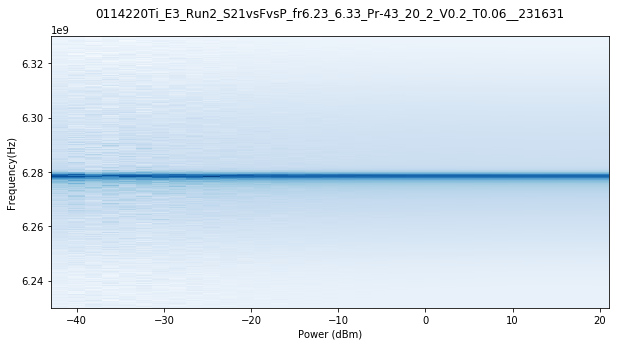

In [9]:
%%time

#########################################################################################

# set up parameters
startFreq, endFreq = 6.23e9, 6.33e9   #Not sure how to set the frequency range?
numPoints, avg = 401, 100
IFStart, IFEnd = 50, 10000 # Hz
startPwr, endPwr, stepPwr = -43, 20, 2 # [dBm]
Vglb_init = 0.2 #For ADR1 [volts]
V2_init = 0   # For ADR2 [volts]

##################

# Sample ID Tag

sampleID = '0114220Ti_E3_Run2'
suffix = ''
#suffix = 'cav2'

save_path = r'Z:\Experiments\Titanium\011420Ti\022020\E3'
#save_path = r'C:\Users\Lab User\Desktop\Crap, please organize\SFQFlipIV\MCMunknown'

commentStr=''  # comment to be placed in the log file.

############################################################################################

# IFbandwidth scales up linearly as power increases.
IF_arr = np.linspace(IFStart, IFEnd, np.arange(startPwr, endPwr + stepPwr, stepPwr).size) 

# dictionary for parameters to be saved in json file. Solely for log.
xID, xStart, xEnd, xStep = 'Power (dBm)', startPwr, endPwr, stepPwr
yID, yStart, yEnd, yStep = 'Frequency (Hz)',startFreq, endFreq, (endFreq-startFreq)/(numPoints-1)
para = dict([('xID', xID), ('xStart', xStart), ('xEnd', xEnd)
             , ('yID', yID), ('yStart', yStart), ('yEnd', yEnd)
             , ('numPoints',numPoints), ('IFbandwidth start (Hz)', IF_arr[0]),('IFbandwidth end (Hz)', IF_arr[-1])
             , ('avg',avg), ('Vglb_init (V)',Vglb_init),('V2_init (V)',V2_init), ('comment', commentStr)])

# file setup
if fridgeType=='ADR2':
    FAA = float(lsci.tempGet('B')) # get temperature
else:
    FAA = 0
timeStr = time.strftime("%H%M%S")
baseStr = sampleID + '_'+'S21vsFvsP_fr{:.9g}_{:.9g}_Pr{:.4g}_{:.4g}_{:.4g}_V{:.3g}_T{:.4g}_{}_{}'
baseFileName = baseStr.format(startFreq/1e9, endFreq/1e9, startPwr, endPwr, stepPwr, Vglb_init, FAA, suffix, timeStr)
dataFileName_mag, dataFileName_phase  = (os.path.join(save_path, baseFileName + '_mag.dat'), 
                                         os.path.join(save_path, baseFileName + '_phase.dat'))
print('filename={}'.format(os.path.join(save_path, baseFileName + '_mag.dat')))
logFileName =  os.path.join(save_path, baseFileName + '.json')
with open(logFileName, 'w') as f:
    json.dump(para,f,indent=4, sort_keys=True)

# plot setup
plotobj= myplots_py3.plot2D(ylabel = 'Frequency(Hz)', xlabel='Power (dBm)', title = baseFileName)

# preconfigure instrument
pna.setupMeas()
time.sleep(0.5)
pna.setSweepType('linear')
time.sleep(0.5)
pna.setFreqStartEnd(startFreq, endFreq)
time.sleep(0.5)
pna.avgCount(avg)
time.sleep(0.5)
pna.numPoints(numPoints)
time.sleep(0.5)
pna.pwrOn()
time.sleep(0.5)
#sim_1.setVoltage(Vglb_init)
#sim_2.setVoltage(V2_init)


# data initialization
S21_mag_log_2D, S21_phase_2D = np.array([]), np.array([])

i=0

# sweep start
for pwr in np.arange(startPwr, endPwr + stepPwr, stepPwr): # traverse in [pmin, pmax].
    
    clear_output()
    print('startPwr={:.3g} dBm, endPwr={:.3g} dBm, current power={:.3g} dBm'.format(startPwr, endPwr, pwr))
    
    # configure
    pna.setIF(IF_arr[i]) 
    time.sleep(0.5)
    pna.setPwr(pwr)
    time.sleep(0.5)
    pna.avgClear()
    time.sleep(0.5)
    i += 1
    
    # fetch data from PNA
    freq, S21 = pna.getData(cplx=True) # S21 in linear scale
    time.sleep(0.5)
    
    # S21 conversion
    S21_real, S21_imag = np.real(S21), np.imag(S21)
    S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
    S21_mag_log = 20.0 * np.log10(S21_mag)    # dB
    
    if S21_mag_log_2D.size == 0: # when S21_mag_2D is empty
        S21_mag_log_2D = S21_mag_log
        #S21_mag_log_2D = S21_real
        S21_mag_log_2D.shape = (S21_mag_log.size, 1)
        S21_phase_2D = S21_phase
        #S21_phase_2D = S21_imag
        S21_phase_2D.shape = (S21_phase.size, 1)
    else:
        S21_mag_log_2D = np.column_stack((S21_mag_log_2D, S21_mag_log))
        S21_phase_2D = np.column_stack((S21_phase_2D, S21_phase))
        #S21_mag_log_2D = np.column_stack((S21_mag_log_2D, S21_real))
        #S21_phase_2D = np.column_stack((S21_phase_2D, S21_imag))
     
    # plot update
    extent = [startPwr, pwr, startFreq, endFreq]
    plotobj.update(S21_mag_log_2D, extent)
        
    # save data in each iteration
    f_mag = open(dataFileName_mag, 'wb') 
    f_phase = open(dataFileName_phase, 'wb') 
    np.savetxt(f_mag, S21_mag_log_2D, fmt='%.9g', delimiter='\t') 
    np.savetxt(f_phase, S21_phase_2D, fmt='%.9g', delimiter='\t')
    f_mag.close()
    f_phase.close()
    
# Post measurement  
pna.setPwr(-50)
time.sleep(0.5)
pna.pwrOff()
time.sleep(0.5)
#sim_1.setVoltage(0)
#sim_2.setVoltage(0)
plotobj.fig.savefig(os.path.join(save_path, baseFileName + '.png'))
print('Measurement complete!!!')


# S21 vs Freq vs Flux, 2D flux scan

startV=-1.5 V, endV=1.5 V, current volt=1.5 V
Measurement done!!!
Wall time: 4min 5s


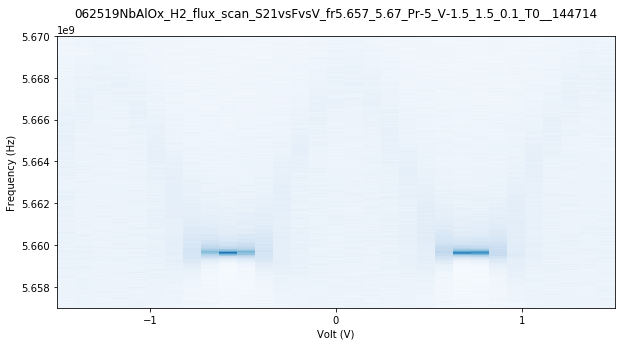

In [6]:
%%time
###########################################################################
# set up parameters
startFreq, endFreq = 5.657e9, 5.67e9   #How do you determine frequency range?
power = -5
numPoints, IFbandwidth, avg = 801, 1000, 10
startVolt, endVolt, stepVolt = -1.5, 1.5, 0.1

sweepVoltSrc = 1 # 1: V1, 2: V2 Tells you if you're using sim1 (sweepVoltSrc=1) or sim2 (sweepVoltSrc=2)
V1_init = 0
V1_end = 0  
V2_init = 0
V2_end = 0

sampleID = '062519NbAlOx_H2_flux_scan'
suffix = ''

save_path = r'Z:\Experiments\Dirty Aluminum\Qubit\062519NbAlOx_H2'

commentStr =''

############################################################################

# dictionary for parameters to be saved in json file. Solely for log.
xID, xStart, xEnd, xStep = 'Volt (V)', startVolt, endVolt, stepVolt
yID, yStart, yEnd, yStep = 'Frequency (Hz)',startFreq, endFreq, (endFreq-startFreq)/(numPoints-1)
para = dict([('xID', xID), ('xStart', xStart), ('xEnd', xEnd)
             , ('yID', yID), ('yStart', yStart), ('yEnd', yEnd), ('Power (dBm)', power)
             , ('numPoints',numPoints), ('IFbandwidth (Hz)', IFbandwidth) 
             , ('avg',avg), ('comment', commentStr)])

# file setup
if fridgeType=='ADR2':
    FAA = float(lsci.tempGet('B')) # get temperature
else :
    FAA = 0    
timeStr = time.strftime("%H%M%S")
baseStr = sampleID + '_S21vsFvsV_fr{:.9g}_{:.9g}_Pr{:.4g}_V{}_{}_{}_T{:.4g}_{}_{}'
baseFileName = baseStr.format(startFreq/1e9, endFreq/1e9, power, startVolt, endVolt, stepVolt, FAA, suffix, timeStr)
dataFileName_mag, dataFileName_phase  = (os.path.join(save_path, baseFileName + '_mag.dat'), 
                                         os.path.join(save_path, baseFileName + '_phase.dat'))
logFileName =  os.path.join(save_path, baseFileName + '.json')
with open(logFileName, 'w') as f:
    json.dump(para,f,indent=4, sort_keys=True)

# plot setup
plotobj= myplots_py3.plot2D(ylabel = 'Frequency (Hz)', xlabel='Volt (V)', title = baseFileName)

# preconfigure instrument
pna.setupMeas()
pna.setSweepType('linear')
pna.setFreqStartEnd(startFreq, endFreq)
pna.setPwr(power)
pna.avgCount(avg)
pna.numPoints(numPoints)
pna.setIF(IFbandwidth)
pna.pwrOn()

sim_1.setVoltage(V1_init)
#sim_2.setVoltage(V2_init)


time.sleep(2)

# data initialization
S21_mag_log_2D, S21_phase_2D = np.array([]), np.array([])

################ sweep start ################
for volt in np.arange(startVolt, endVolt + stepVolt, stepVolt): # traverse in [pmin, pmax].
    clear_output()
    print('startV={:.3g} V, endV={:.3g} V, current volt={:.3g} V'.format(startVolt, endVolt, volt))

    # configure
    if sweepVoltSrc==1:
        sim_1.setVoltage(volt)
#         pass
    elif sweepVoltSrc==2:
        sim_2.setVoltage(volt)
        
    #time.sleep(0.5)
    pna.avgClear()
    
    # fetch data from PNA
    freq, S21 = pna.getData(cplx=True) # S21 in linear scale
    
    # S21 conversion
    S21_real, S21_imag = np.real(S21), np.imag(S21)
    S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
    S21_mag_log = 20.0 * np.log10(S21_mag)    # dB
    
    if S21_mag_log_2D.size == 0: # when S21_mag_2D is empty
        S21_mag_log_2D = S21_mag_log
        #S21_mag_log_2D = S21_real
        S21_mag_log_2D.shape = (S21_mag_log.size, 1)
        S21_phase_2D = S21_phase
        #S21_phase_2D = S21_imag
        S21_phase_2D.shape = (S21_phase.size, 1)
    else:
        S21_mag_log_2D = np.column_stack((S21_mag_log_2D, S21_mag_log))
        S21_phase_2D = np.column_stack((S21_phase_2D, S21_phase))
        #S21_mag_log_2D = np.column_stack((S21_mag_log_2D, S21_real))
        #S21_phase_2D = np.column_stack((S21_phase_2D, S21_imag))
    
    # plot update
    extent = [startVolt, volt, startFreq, endFreq]

        
    # save data in each iteration
#     f_mag = open(dataFileName_mag, 'w') 
#     f_phase = open(dataFileName_phase, 'w') 
#     np.savetxt(f_mag, S21_mag_log_2D, fmt='%.9g', delimiter='\t') 
#     np.savetxt(f_phase, S21_phase_2D, fmt='%.9g', delimiter='\t')
#     f_mag.close()
#     f_phase.close()
    
############## sweep end #########################    
# save at the end
plotobj.update(S21_mag_log_2D, extent)
f_mag = open(dataFileName_mag, 'wb') 
f_phase = open(dataFileName_phase, 'wb') 
np.savetxt(f_mag, S21_mag_log_2D, fmt='%.9g', delimiter='\t') 
np.savetxt(f_phase, S21_phase_2D, fmt='%.9g', delimiter='\t')
f_mag.close()
f_phase.close()

 
# Post measurement   
plotobj.update(S21_mag_log_2D, extent)
del S21_mag_log_2D, S21_phase_2D
pna.pwrOff()
sim_1.setVoltage(0)
#sim_2.setVoltage(0)
plotobj.fig.savefig(os.path.join(save_path, baseFileName + '.png'))
print('Measurement done!!!')

# S21 vs Freq vs Flux, 3D flux scan

In [4]:
%%time
###########################################################################
# set up parameters
startFreq, endFreq = 5.93e9, 6.03e9 # 6.935e9, 6.9450e9 #6.7949e9 , 6.9676e9 #6.83e9, 6.894e9#6.856e9, 7.015e9 #6.85e9, 7.05e9
power = -60
numPoints, IFbandwidth, avg = 801, 1000, 10
startVolt, endVolt, stepVolt = -1.5, 1.5, 0.1 #-5, 5, 0.05 #  #-15, 15, 0.4#-20, 20, 0.5 #-1, 1.5, 0.04
endV = 0  # end voltage for both global and onchip flux
#startVolt1, endVolt1, stepVolt1 =-5.3, 0.7, 0.05

#slop, Vglb_offset = -0.0659, -0.5  # Vglb = slope * Vchip + Vglb_offset. Vglb_offset is the y-intercept in Vchip(x-axxis) vs Vglb (y) axis.

#save_path = 'Z:\User\JJ\SFQ2\C6'
save_path = r'Z:\User\Andrew\Flip-Chip_measurements'
sampleID = 'AB44'
suffix = 'chip1_Cav1'
commentStr= ''.format(slope, Vglb_offset)
############################################################################

# dictionary for parameters to be saved in json file. Solely for log.
xID, xStart, xEnd, xStep = 'Volt (V)', startVolt, endVolt, stepVolt
yID, yStart, yEnd, yStep = 'Frequency (Hz)',startFreq, endFreq, (endFreq-startFreq)/(numPoints-1)
zID, zStart, zEnd, zStep = 'Volt (V)', startVolt1, endVolt1, stepVolt1
para = dict([('xID', xID), ('xStart', xStart), ('xEnd', xEnd)
             , ('yID', yID), ('yStart', yStart), ('yEnd', yEnd)
             ,('zID', zID), ('zStart', zStart), ('zEnd', zEnd), ('Power (dBm)', power)
             , ('numPoints',numPoints), ('IFbandwidth (Hz)', IFbandwidth) 
             , ('avg',avg), ('comment', commentStr)])

# log file setup
if fridgeType=='ADR2':
    FAA = float(lsci.tempGet('B')) # get temperature
else FAA = 0
timeStr = time.strftime("%H%M%S")
baseStr = 'S21vsFvsV_fr{:.9g}_{:.9g}_Pr{:.4g}_V{}_{}_{}_T{:.4g}_{}_{}'
baseFileName = baseStr.format(startFreq/1e9, endFreq/1e9, power, startVolt, endVolt, stepVolt, FAA, suffix,timeStr)
logFileName =  os.path.join(save_path, baseFileName + '.json')
with open(logFileName, 'w') as f:
    json.dump(para,f,indent=4, sort_keys=True)

# plot setup
#plotobj= myplots.plot2D(ylabel = 'Frequency(Hz)', xlabel='Volt (V)', title = 'S21 vs Freq vs Volt')

# preconfigure instrument
pna.setupMeas()
pna.setSweepType('linear')
pna.setFreqStartEnd(startFreq, endFreq)
pna.setPwr(power)
pna.avgCount(avg)
pna.numPoints(numPoints)
pna.setIF(IFbandwidth)
pna.pwrOn()

sim_glb.setVoltage(slope * startVolt + Vglb_offset)
sim_chip.setVoltage(startVolt)

time.sleep(2)

################ sweep start ################
for Vglb_offset in np.arange(startVolt1, endVolt1+stepVolt1, stepVolt1):
    # data initialization
    S21_mag_log_2D, S21_phase_2D = np.array([]), np.array([])

    #sim_glb.setVoltage(volt_outer)
    
    for volt_inner in np.arange(startVolt, endVolt + stepVolt, stepVolt): # traverse in [pmin, pmax].
        clear_output()
        print('Vglb_offset={:.3g}'.format(Vglb_offset))
        print('startV={:.3g} V, endV={:.3g} V, current volt={:.3g} V'.format(startVolt, endVolt, volt_inner))

        # configure
        sim_chip.setVoltage(volt_inner)
        sim_glb.setVoltage(slope * volt_inner + Vglb_offset)
        time.sleep(0.1)
        pna.avgClear()

        # fetch data from PNA
        freq, S21 = pna.getData(cplx=True) # S21 in linear scale

        # S21 conversion
        S21_real, S21_imag = np.real(S21), np.imag(S21)
        S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
        S21_mag_log = 20.0 * np.log10(S21_mag)    # dB

        if S21_mag_log_2D.size == 0: # when S21_mag_2D is empty
            S21_mag_log_2D = S21_mag_log
            S21_mag_log_2D.shape = (S21_mag_log.size, 1)
            S21_phase_2D = S21_phase
            S21_phase_2D.shape = (S21_phase.size, 1)
        else:
            S21_mag_log_2D = np.column_stack((S21_mag_log_2D, S21_mag_log))
            S21_phase_2D = np.column_stack((S21_phase_2D, S21_phase))

        # plot update
        #extent = [startVolt, volt, startFreq, endFreq]
        #plotobj.update(S21_mag_log_2D, extent)
     
    sim_chip.setVoltage(endV)
    time.sleep(3)
     
    # save at the end of inner loop
    fileIdStr = '_Vglb_offset={:.3g}'.format(Vglb_offset)
    dataFileName_mag, dataFileName_phase  = (os.path.join(save_path, baseFileName + fileIdStr + '_mag.dat'), 
                                             os.path.join(save_path, baseFileName + fileIdStr + '_phase.dat'))
    f_mag = open(dataFileName_mag, 'w') 
    f_phase = open(dataFileName_phase, 'w') 
    np.savetxt(f_mag, S21_mag_log_2D, fmt='%.9g', delimiter='\t') 
    np.savetxt(f_phase, S21_phase_2D, fmt='%.9g', delimiter='\t')
    f_mag.close()
    f_phase.close()
############## sweep end #########################    

# Post measurement   
del S21_mag_log_2D, S21_phase_2D
pna.pwrOff()
sim_glb.setVoltage(endV)
sim_chip.setVoltage(endV)
print('Measurement done!!!')

SyntaxError: invalid syntax (<unknown>, line 32)

# S21 vs Flux1 vs Flux2, 2D flux scan

In [ ]:
%reset

In [ ]:
import sys
for i in dir():
    try:
        print (i, eval(i).nbytes )
    except:
        print (i, sys.getsizeof(eval(i)) )

In [ ]:
%%time
##############################################################################
# set up parameters
readoutPwr = -75
readoutFreq = 7.14567e9 #6.7917e9 #6.792e9 #6.82e9 
numPoints, IFbandwidth, avg = 30, 500, 1
startVolt1, endVolt1, stepVolt1 =-3, 3, 0.02#-10, 10, 0.2 #-10, 10, 0.05 #-1.2, 1, 0.025 # outer for-loop
startVolt2, endVolt2, stepVolt2 =-20,20, 0.25 #-20, 20, 0.5 #-20, 20, 0.5 # y axis. Inner for-loop.
endVolt = 0

suffix = 'Q6_V2=onchip'
save_path =  r'Z:\User\Jaseung\projects\CSFQ\measurement\W10\B2\ADR2'
commentStr='with spec setup'
##############################################################################

xID, xStart, xEnd, xStep = 'Volt1 (V)', startVolt1, endVolt1, stepVolt1
yID, yStart, yEnd, yStep = 'Volt2 (V)', startVolt2, endVolt2, stepVolt2
para = dict([('xID', xID), ('xStart', xStart), ('xEnd', xEnd)
             , ('yID', yID), ('yStart', yStart), ('yEnd', yEnd)
             , ('readoutFreq (Hz)',readoutFreq),('power (dBm)',readoutPwr)
             , ('numPoints',numPoints), ('IFbandwidth (Hz)', IFbandwidth) 
             , ('avg',avg), ('comment', commentStr)])

# file setup
if fridgeType=='ADR2':
    FAA = float(lsci.tempGet('B')) # get temperature
else:
    FAA = 0

baseStr = 'S21vsV1vsV2_fr{:.9g}_Pr{:.4g}_V1_{}_{}_{}_V2_{}_{}_{}_T{:.4g}_{}'
baseFileName = baseStr.format(readoutFreq/1e9, readoutPwr, startVolt1, endVolt1, stepVolt1, startVolt2, endVolt2, stepVolt2, FAA, suffix)
dataFileName1  = os.path.join(save_path, baseFileName + '_mag.dat')
dataFileName2  = os.path.join(save_path, baseFileName + '_phase.dat')
logFileName =  os.path.join(save_path, baseFileName + '.json')
with open(logFileName, 'w') as f_log:
    json.dump(para, f_log, indent=4, sort_keys=True)

# plot setup
plotobj= myplots_py3.plot2D_4sub(xlabel1 = 'Voltage2 (V)', ylabel1='S21 (dB)', 
                             xlabel2 = 'Voltage2 (V)', ylabel2='Phase(degree)',
                             xlabel3 = 'Voltage, Vglb (V)', ylabel3='Voltage, Vchip (V)',
                             xlabel4 = 'Voltage, Vglb (V)', ylabel4='Voltage, Vchip (V)',
                             title = 'S21 vs Global Flux vs Gradiometric Flux', figsize=(12,8))

# preconfigure instrument
pna.setupMeas()
pna.setSweepType(mode='CW')
pna.setCWFreq(readoutFreq)
pna.setPwr(readoutPwr)
pna.avgCount(avg)
pna.numPoints(numPoints)
pna.setIF(IFbandwidth)
pna.pwrOn()

sim_glb.setVoltage(startVolt1)
time.sleep(2)
sim_chip.setVoltage(startVolt2)
time.sleep(2)

# data initialization
data1_2D, data2_2D = np.array([]), np.array([])

################ sweep start ################
#for specFreq in arange(startFreq, endFreq + stepFreq, stepFreq): # traverse in [pmin, pmax].
for volt1 in np.arange(startVolt1, endVolt1 + stepVolt1, stepVolt1):
    #configure para
    sim_glb.setVoltage(volt1)
    
    # data initialization
    xdata1, ydata1, ydata2 = np.array([]), np.array([]), np.array([])
    
    for volt2 in np.arange(startVolt2, endVolt2 + stepVolt2, stepVolt2):
        clear_output()
        print('startVolt1={:.3g}, endtvolt1={:.3g}'.format(startVolt1, endVolt1))
        print('startVolt2={:.3g}, endtvolt2={:.3g}'.format(startVolt2, endVolt2))
        print('volt1={:.3g}, volt2={:.3g}'.format(volt1, volt2)) 
        
        # configure
        pna.avgClear()
        sim_chip.setVoltage(volt2)
    
        # fetch data from PNA
        freq, S21= pna.getData(cplx=True) # S21 in linear scale
    
        # S21 conversion
        S21_real, S21_imag = np.real(S21), np.imag(S21)
        S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
        S21_mag_log = 20.0 * np.log10(S21_mag)    # dB

        S21_mag_log_avg = np.average(S21_mag_log) 
        S21_phase_avg = np.average(S21_phase)

        xdata1 = np.append(xdata1, volt2)
        ydata1 = np.append(ydata1, S21_mag_log_avg)
        ydata2 = np.append(ydata2, S21_phase_avg)

        # plot and update
        plotobj.update1D(xdata1, ydata1, xdata1, ydata2)

    
    if data1_2D.size == 0: # when S21_mag_2D is empty
        data1_2D = ydata1 # make 2D array
        data1_2D.shape = (data1_2D.size, 1)
        data2_2D = ydata2
        data2_2D.shape = (data2_2D.size, 1)
        
    else:
        data1_2D = np.column_stack((data1_2D, ydata1))
        data2_2D = np.column_stack((data2_2D, ydata2))
             
    # plot and update
    extent = [startVolt1, volt1, startVolt2, endVolt2]
    plotobj.update2D(data1_2D, data2_2D, extent, cmap='Blues_r')
    
    # save data in each iteration
    f_mag = open(dataFileName1, 'wb') 
    f_phase = open(dataFileName2, 'wb') 
    np.savetxt(f_mag, data1_2D, fmt='%.9g', delimiter='\t') 
    np.savetxt(f_phase, data2_2D, fmt='%.9g', delimiter='\t')
    f_mag.close()
    f_phase.close()
     
############## sweep end #########################    

# Post measurement    
pna.pwrOff()
pna.setSweepType(mode='linear')
sim_glb.setVoltage(endVolt)
sim_chip.setVoltage(endVolt)
f_log.close()
plotobj.fig.savefig(os.path.join(save_path, baseFileName + '.png'))
print('Measurement done!!!')

# S21 vs Freq vs Flux (linear comb. of flux1 and flux2), 2D

In [ ]:
reload(myplots)

In [ ]:
%%time
###########################################################################
# set up parameters
startFreq, endFreq =  6.77e9, 6.81e9 #6.83e9, 6.894e9#6.856e9, 7.015e9 #6.85e9, 7.05e9
power = -60
numPoints, IFbandwidth, avg = 801, 1000, 1
startVolt, endVolt, stepVolt =-20, 20, 0.2#-20, 20, 0.5 #-1, 1.5, 0.04
endV = 0

slope, Vglb_offset =-0.3378,2.4 # 0.2107, 0# 2.484#-0.3378, -0.9641# -0.0659, 0.7   # offset means Vglb when Vchip=0

#save_path = 'Z:\User\JJ\sput\M5_1_spec'
save_path = 'Z:\User\Jaseung\projects\CSFQ\measurement\W3\B7\BlueFors\Jan2017\S21vsFreqvsV'
suffix = 'Q1_xID=Vchip_slope{}_Vglb_offset{}'.format(slope, Vglb_offset)
comment= 'slope={:.3g}, Vglb_offset={:.3g}'.format(slope, Vglb_offset)

plottitle = 'S21 vs Freq vs Vchip, Vglb_offset={:.3g}'.format(Vglb_offset)

############################################################################

# dictionary for parameters to be saved in json file. Solely for log.
xID, xStart, xEnd, xStep = 'Volt (V)', startVolt, endVolt, stepVolt
yID, yStart, yEnd, yStep = 'Frequency (Hz)',startFreq, endFreq, (endFreq-startFreq)/(numPoints-1)
para = dict([('xID', xID), ('xStart', xStart), ('xEnd', xEnd)
             , ('yID', yID), ('yStart', yStart), ('yEnd', yEnd), ('Power (dBm)', power)
             , ('numPoints',numPoints), ('IFbandwidth (Hz)', IFbandwidth) 
             , ('avg',avg), ('comment', comment)])

# file setup
if fridgeType=='ADR2':
    FAA = float(lsci.tempGet('B')) # get temperature
else FAA = 0

baseStr = 'S21vsFvsV_fr{:.9g}_{:.9g}_Pr{:.4g}_V{}_{}_{}_T{:.4g}_{}'
baseFileName = baseStr.format(startFreq/1e9, endFreq/1e9, power, startVolt, endVolt, stepVolt, FAA, suffix)
dataFileName_mag, dataFileName_phase  = (os.path.join(save_path, baseFileName + '_mag.dat'), 
                                         os.path.join(save_path, baseFileName + '_phase.dat'))
logFileName =  os.path.join(save_path, baseFileName + '.json')
with open(logFileName, 'w') as f:
    json.dump(para,f,indent=4, sort_keys=True)

# plot setup
plotobj= myplots.plot2D(ylabel = 'Frequency(Hz)', xlabel='Volt (V)', title = plottitle)

# preconfigure instrument
pna.setupMeas()
pna.setSweepType('linear')
pna.setFreqStartEnd(startFreq, endFreq)
pna.setPwr(power)
pna.avgCount(avg)
pna.numPoints(numPoints)
pna.setIF(IFbandwidth)
pna.pwrOn()

sim_glb.setVoltage(slope*startVolt+Vglb_offset)
sim_chip.setVoltage(startVolt)
time.sleep(2)

# data initialization
S21_mag_log_2D, S21_phase_2D = np.array([]), np.array([])

################ sweep start ################
for volt_chip in np.arange(startVolt, endVolt + stepVolt, stepVolt): # traverse in [pmin, pmax].
    # configure
    volt_glb =  slope * volt_chip + Vglb_offset
    #volt_glb = -1/slope* (volt_chip-20) - 0.55
    clear_output()
    print('volt_glb={:.3g}, volt_chip={:.3g}'.format(volt_glb, volt_chip))
    sim_chip.setVoltage(volt_chip)
    sim_glb.setVoltage(volt_glb)
    
    time.sleep(0.1)
    pna.avgClear()
    
    # fetch data from PNA
    freq, S21 = pna.getData(cplx=True) # S21 in linear scale
    
    # S21 conversion
    S21_real, S21_imag = np.real(S21), np.imag(S21)
    S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
    S21_mag_log = 20.0 * np.log10(S21_mag)    # dB
    
    if S21_mag_log_2D.size == 0: # when S21_mag_2D is empty
        S21_mag_log_2D = S21_mag_log
        S21_mag_log_2D.shape = (S21_mag_log.size, 1)
        S21_phase_2D = S21_phase
        S21_phase_2D.shape = (S21_phase.size, 1)
    else:
        S21_mag_log_2D = np.column_stack((S21_mag_log_2D, S21_mag_log))
        S21_phase_2D = np.column_stack((S21_phase_2D, S21_phase))
     
    # plot update
    extent = [startVolt, volt_chip, startFreq, endFreq]
    plotobj.update(S21_mag_log_2D, extent)
        
    # save data in each iteration
    f_mag = open(dataFileName_mag, 'w') 
    f_phase = open(dataFileName_phase, 'w') 
    np.savetxt(f_mag, S21_mag_log_2D, fmt='%.9g', delimiter='\t') 
    np.savetxt(f_phase, S21_phase_2D, fmt='%.9g', delimiter='\t')
    f_mag.close()
    f_phase.close()
    
############## sweep end #########################    

# Post measurement    
pna.pwrOff()
sim_glb.setVoltage(endV)
sim_chip.setVoltage(endV)
plotobj.fig.savefig(os.path.join(save_path, baseFileName + '.png'))
print('Measurement done!!!')

# S21 vs Freq, 1D continuous sweep, no save

In [ ]:
# set up parameters
startFreq, endFreq = 6e9, 6.867e9
power = -60
numPoints, IFbandwidth, avg = 401, 500, 1
#volt = 0.0 # -0.65 # -2.05  #2.4

# plot setup
plotobj= myplots_py3.plot1D(ylabel = 'S21 (dB)', xlabel='Frequency (Hz)', title = 'S21 vs Freq'
                        , plotStyle='b-o')

# preconfigure instrument
pna.setupMeas()
pna.setSweepType('linear')
pna.setFreqStartEnd(startFreq, endFreq)
pna.setPwr(power)
pna.avgCount(avg)
pna.numPoints(numPoints)
pna.setIF(IFbandwidth)
pna.pwrOn()

#spec.pwrOff()
#sim_glb.setVoltage(volt)

# data initialization
S21_mag_log_2D, S21_phase_2D = np.array([]), np.array([])

################ sweep start ################
for i in range(400):
    # configure
    pna.avgClear()
        
    # fetch data from PNA
    freq, S21 = pna.getData(cplx=True) # S21 in linear scale
    
    # S21 conversion
    S21_real, S21_imag = np.real(S21), np.imag(S21)
    S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
    S21_mag_log = 20.0 * np.log10(S21_mag)    # dB
    
    # plot update
    plotobj.update(freq/1e9, S21_mag_log)
       
############## sweep end #########################    

# Post measurement    
pna.pwrOff()


# S21 vs Flux, 1D, CW mode

In [ ]:
####################################################################################################
# set up parameters
readoutFreq = 6.9078e9 #6.9180e9 #6.873328e9
readoutPwr = -70
numPoints, IFbandwidth, avg = 50, 100, 1
startVolt, endVolt, stepVolt =0.2, 0.5, 0.003
endV = 0
sweepNumber = 1
timesleep = 0.1 # sec

sampleID = 'IBM384QB56'
suffix = 'Q2CSFQ'
# save_path = 'C:\Users\Lab User\Desktop\W4'
#save_path = r'Z:\User\Jaseung\projects\CSFQ\measurement\W11\DD5\ADR2'
save_path = r'Z:\User\Jaseung\projects\CSFQ\measurement\IBM\384QB56\BF\With_circulators'
#save_path = r'Y:\User\Caleb'
######################################################################################################

# dictionary for parameters to be saved in json file. Solely for log.
header = '{:s} {:s} {:s}'.format('Frequency(Hz)', 'mag(dB)', 'phase(degree)')
para = dict([('readout Freq (Hz)',readoutFreq),('readout Power (dBm)', readoutPwr),('numPoints',numPoints),
             ('IFbandwidth (Hz)', IFbandwidth),('avg',avg),('start volt (V)',startVolt),('end volt (V)', endVolt),
             ('step volt (V)',stepVolt), ('header', header)])


# file setup
if fridgeType=='ADR2':
    FAA = float(lsci.tempGet('B')) # get temperature
else :
    FAA = 0    
timeStr = time.strftime("%H%M%S")
baseStr = sampleID + '_S21vsV_fr{:.9g}_Pr{:.9g}_V{:.9g}_{:.9g}_{:.9g}_T{:.3g}_{}_{}'
baseFileName = baseStr.format(readoutFreq/1e9, readoutPwr, startVolt, endVolt, stepVolt, FAA, suffix, timeStr)
dataFileName  = os.path.join(save_path, baseFileName + '.dat')
logFileName = os.path.join(save_path, baseFileName + '.json')
with open(logFileName, 'w') as f:
    json.dump(para,f,indent=4, sort_keys=True)

f_data = open(dataFileName, 'a')
   
# plot setup
plotobj= myplots_py3.plot1D_2sub(xlabel1 = '', ylabel1='S21 (dB)', 
                             xlabel2 = 'Volt (V)', ylabel2='Phase(degree)',
                             title = baseFileName, plotStyle='b-')

# preconfigure instrument
pna.setupMeas()
pna.setSweepType('CW')
pna.setCWFreq(readoutFreq)
pna.setPwr(readoutPwr)
pna.avgCount(avg)
pna.numPoints(numPoints)
pna.setIF(IFbandwidth)
pna.pwrOn()

#spec.pwrOff()
sim_glb.setVoltage(startVolt)
#sim_chip.setVoltage(0)

#sim_glb.setVoltage(0.148)
#sim_chip.setVoltage(startVolt)

# data initialization
xdata, ydata1, ydata2 = np.array([]), np.array([]),np.array([])

# sweeper obj
sweeper = myutils.Sweeper1D(start=startVolt, end=endVolt, 
                            step=stepVolt, sweepNum=sweepNumber)

################ sweep start ################
#for specFreq in arange(startFreq, endFreq + stepFreq, stepFreq): # traverse in [pmin, pmax].
print(sweeper.stop())

while not sweeper.stop(): 
    # configure
    sim_glb.setVoltage(sweeper.curr_val)
    #sim_chip.setVoltage(sweeper.curr_val)
    
    time.sleep(timesleep) # sec
    pna.avgClear()
    
    # fetch data from PNA
    freq, S21= pna.getData(cplx=True) # S21 in linear scale
    
    # S21 conversion
    S21_real, S21_imag = np.real(S21), np.imag(S21)
    S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
    S21_mag_log = 20.0 * np.log10(S21_mag)    # dB
    S21_mag_log_avg = np.average(S21_mag_log) 
    S21_phase_avg = np.average(S21_phase)
    
    # create spec freq, S21 1D array
    xdata = np.append(xdata, sweeper.curr_val)
    ydata1 = np.append(ydata1, S21_mag_log_avg)
    ydata2 = np.append(ydata2, S21_phase_avg)
    
    # plot and update
    plotobj.update(xdata, ydata1, xdata, ydata2)
    
    # save data in each iteration
    string = '{:.9g}\t{:.3g}\t{:.3g} \n'.format(sweeper.curr_val, S21_mag_log_avg,S21_phase_avg)
    f_data.write(string)
    
    # update sweep
    sweeper.update()
############## sweep end #########################    

# Post measurement    
pna.pwrOff()
pna.setSweepType(mode='linear')
sim_glb.setVoltage(endV)
#sim_chip.setVoltage(endV)
f_data.close()
f.close()
plotobj.fig.savefig(os.path.join(save_path, baseFileName + '.png'))
print('Measurement done!!')


# S21 vs P, 1D, CW mode

In [ ]:
##################################################################
# set up parameters
readoutFreq = 6.103142e9 #6.873328e9
numPoints, IFbandwidth, avg = 50, 200, 1
startPwr, endPwr, stepPwr = -70, -40, 0.5
volt = 0
sweepNumber = 1

sampleID = ''
suffix = ''  # suffix to the file name
save_path = 'C:\Users\Lab User\Desktop\JJ\A4'
#save_path = 'Z:\User\Jaseung\projects\CSFQ\W1\C5\S21vsFreq'
##################################################################

# dictionary for parameters to be saved in json file. Solely for log.
para = dict([('readout Freq (Hz)',readoutFreq),('numPoints',numPoints)
             ,('IFbandwidth', IFbandwidth),('avg',avg)
             ,('Power start (dBm)',startPwr),('Power end (dBm)',endPwr), ('Power step (dBm)',stepPwr)
             ,('voltage (V)',volt)])

# file setup
FAA = float(lsci.tempGet('B')) # unicode to num    
baseStr = sampleID + '_S21vsP_fr{:.9g}_Pr{:.9g}_{:.9g}_{:.9g}_V{:.3g}_T{:.4g}_{}'
baseFileName = baseStr.format(readoutFreq/1e9, startPwr, endPwr, stepPwr, volt, FAA, suffix)
dataFileName  = os.path.join(save_path, baseFileName + '.dat')
logFileName = os.path.join(save_path, baseFileName + '.json')
with open(logFileName, 'w') as f:
    json.dump(para,f,indent=4, sort_keys=True)
f_data = open(dataFileName, 'a')
    
# plot setup
plotobj= myplots.plot1D_2sub(xlabel1 = '', ylabel1='S21 (dB)', 
                             xlabel2 = 'Volt (V)', ylabel2='Phase(degree)',
                             title = 'S21 vs Volt', plotStyle='b-o')

# preconfigure instrument
pna.setupMeas()
pna.setSweepType('CW')
pna.setCWFreq(readoutFreq)
pna.avgCount(avg)
pna.numPoints(numPoints)
pna.setIF(IFbandwidth)
pna.pwrOn()
#spec.pwrOff()
sim_glb.setVoltage(volt)

# data initialization
xdata, ydata1, ydata2 = np.array([]), np.array([]),np.array([])

# sweeper obj
sweeper = myutils.Sweeper1D(start=startPwr, end=endPwr, step=stepPwr, sweepNum=sweepNumber)

################ sweep start ################
while not sweeper.stop(): 
    # configure
    pna.setPwr(sweeper.curr_val)
    pna.avgClear()
    
    # fetch data from PNA
    freq, S21= pna.getData(cplx=True) # S21 in linear scale
    
    # S21 conversion
    S21_real, S21_imag = np.real(S21), np.imag(S21)
    S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
    S21_mag_log = 20.0 * np.log10(S21_mag)    # dB
    S21_mag_log_avg = np.average(S21_mag_log) 
    S21_phase_avg = np.average(S21_phase)
    
    # create spec freq, S21 1D array
    xdata = np.append(xdata, sweeper.curr_val)
    ydata1 = np.append(ydata1, S21_mag_log_avg)
    ydata2 = np.append(ydata2, S21_phase_avg)
    
    # plot and update
    plotobj.update(xdata, ydata1, xdata, ydata2)
    
    # save data in each iteration
    string = '{:.9g}\t{:.3g}\t{:.3g} \n'.format(sweeper.curr_val, S21_mag_log_avg,S21_phase_avg)
    f_data.write(string)
    
    # update sweep
    sweeper.update()
############## sweep end #########################    

# Post measurement    
pna.pwrOff()
pna.setSweepType(mode='linear')
#sim_glb.setVoltage(endV)
f_data.close()
plotobj.fig.savefig(os.path.join(save_path, baseFileName + '.png'))
print('Measurement finished!!!')

# Resonator Power scan

In [4]:
#################################################################################
# set up parameters
startFreq, endFreq =6.407e9, 6.408e9
power = -20
numPoints, IFbandwidth, avg = 1001, 1000, 3
volt = 0 # -0.65 # -2.05  #2.4

sampleID = 'W19B4'
suffix = 'R4'  # suffix to the file name
#save_path = r'Z:\User\Yebin\Project\Resonator Qi test\Samples\12062017_W10'
save_path = r'Z:\User\Yebin\Project\Resonator Qi test\Samples\07022018-W19-HF after photolithography_ADR2'
#################################################################################

# dictionary for parameters to be saved in log file.
header = 'freq (Hz) mag(dB) phase(degree) real imag'
para = dict([('startFreq (Hz)',startFreq),('endFreq (Hz)', endFreq),('power (dBm)',power)
             ,('numPoints',numPoints), ('IFbandwidth (Hz)', IFbandwidth),('avg',avg)
             ,('volt',volt), ('header', header)])

# file setup
if fridgeType=='ADR2':
    FAA = float(lsci.tempGet('B')) # get temperature
else :
    FAA = 0 
timeStr = time.strftime("%H%M%S")
baseStr = sampleID + '_S21vsF_fr{:.9g}_{:.9g}_Pr{}_V{}_T{:.4g}_{}'
baseFileName = baseStr.format(startFreq/1e9, endFreq/1e9, power, volt, FAA, timeStr)
dataFileName = os.path.join(save_path, baseFileName + '.dat')                                 
logFileName =  os.path.join(save_path, baseFileName + '.json')

with open(logFileName, 'w') as f:
    json.dump(para,f,indent=4, sort_keys=True)

# plot setup
plotobj= myplots_py3.plot1D(ylabel = 'S21 (dB)', xlabel='Frequency (Hz)', title = baseFileName, plotStyle='b-')

# configure instrument
pna.setupMeas()
pna.setSweepType('linear')
pna.setFreqStartEnd(startFreq, endFreq)
pna.setPwr(power)
pna.avgCount(avg)
pna.numPoints(numPoints)
pna.setIF(IFbandwidth)
pna.pwrOn()

#sim_glb.setVoltage(volt)

# data initialization
#S21_mag_log_2D, S21_phase_2D = np.array([]), np.array([])
data = np.array([])

# configure
pna.avgClear()
        
# fetch data from PNA
freq, S21 = pna.getData(cplx=True) # S21 in linear scale
 
# S21 conversion
S21_real, S21_imag = np.real(S21), np.imag(S21)
S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
S21_mag_log = 20.0 * np.log10(S21_mag)    # dB

# make 2D array with freq, dB, phase
data = freq
data.shape = (freq.size, 1)
data = np.column_stack((data, S21_mag_log))
data = np.column_stack((data, S21_phase))
data = np.column_stack((data, S21_real))
data = np.column_stack((data, S21_imag))
     
# plot update
plotobj.update(freq/1e9, S21_mag_log)

# save files
f = open(dataFileName, 'wb') 
np.savetxt(f, data, fmt='%.9g', delimiter='\t') 

# Post measurement   

pna.pwrOff()
f.close()
plotobj.fig.savefig(os.path.join(save_path, baseFileName + '.png'))
print('Measurement finished!!!')

Initialized S21 Measurement 'S21Meas'
Measurement finished!!!


In [5]:
def cav1d(startFreq, endFreq,power,numPoints, IFbandwidth, avg,width,suffix = 'R5',sampleID ='W5', \
          save_path=r'Z:\User\Yebin\Project\Resonator Qi test\Samples\02192018_W5Res_HFinCNF_Post descum\data\R5'):
    #################################################################################
    # set up parameters   
    volt = 0 # -0.65 # -2.05  #2.4
    #suffix = 'Q4'  # suffix to the file name
    #################################################################################

    # dictionary for parameters to be saved in log file.
    header = 'freq (Hz) mag(dB) phase(degree) real imag'
    para = dict([('power (dBm)',power),('startFreq (Hz)',startFreq),('endFreq (Hz)', endFreq)
                 ,('numPoints',numPoints), ('IFbandwidth (Hz)', IFbandwidth),('avg',avg)
                 ,('volt',volt), ('header', header)])

    # file setup
    if fridgeType=='ADR2':
        FAA = float(lsci.tempGet('B')) # get temperature
    else :
        FAA = 0.0 
    timeStr = time.strftime("%H%M%S")
    baseStr = sampleID + '_S21vsF_Pr{}_fr{:.9g}_{:.9g}_V{}_T{:.4g}_{}_{}_{}'
    baseFileName = baseStr.format(power,startFreq/1e9, endFreq/1e9, volt, FAA,width,suffix, timeStr)
    dataFileName = os.path.join(save_path, baseFileName + '.dat')                                 
    logFileName =  os.path.join(save_path, baseFileName + '.json')

    with open(logFileName, 'w') as f:
        json.dump(para,f,indent=4, sort_keys=True)

    # plot setup
    plotobj= myplots_py3.plot1D(ylabel = 'S21 (dB)', xlabel='Frequency (Hz)', title = baseFileName, plotStyle='b-')

    # configure instrument
    pna.setupMeas()
    pna.setSweepType('linear')
    pna.setFreqStartEnd(startFreq, endFreq)
    pna.setPwr(power)
    pna.avgCount(avg)
    pna.numPoints(numPoints)
    pna.setIF(IFbandwidth)
    pna.pwrOn()

    #sim_glb.setVoltage(volt)

    # data initialization
    #S21_mag_log_2D, S21_phase_2D = np.array([]), np.array([])
    data = np.array([])

    # configure
    pna.avgClear()

    # fetch data from PNA
    freq, S21 = pna.getData(cplx=True) # S21 in linear scale

    # S21 conversion
    S21_real, S21_imag = np.real(S21), np.imag(S21)
    S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
    S21_mag_log = 20.0 * np.log10(S21_mag)    # dB

    # make 2D array with freq, dB, phase
    data = freq
    data.shape = (freq.size, 1)
    data = np.column_stack((data, S21_mag_log))
    data = np.column_stack((data, S21_phase))
    data = np.column_stack((data, S21_real))
    data = np.column_stack((data, S21_imag))

    # plot update
    plotobj.update(freq/1e9, S21_mag_log)

    # save files
    f = open(dataFileName, 'wb') 
    np.savetxt(f, data, fmt='%.9g', delimiter='\t') 

    # Post measurement    
    pna.pwrOff()
    f.close()
    plotobj.fig.savefig(os.path.join(save_path, baseFileName + '.png'))
    print('Measurement finished!!!')
    return data

In [6]:
def Get_S21(freqStart, freqEnd,power,numPoints, IFbandwidth, avg,wideSpan,suffix = 'Q4',sampleID ='W14', \
          save_path=r'Z:\User\Yebin\Project\Resonator Qi test\Samples'):
    #get data 1 WS scan
    freqCenter = (freqStart + freqEnd)/2
    freqStartW = freqCenter - wideSpan/2
    freqEndW = freqCenter + wideSpan/2 
    dataS = cav1d(freqStart, freqEnd,power,numPoints,IFbandwidth, avg,'SS',suffix,sampleID,save_path) 
    dataW = cav1d(freqStartW, freqEndW,power,numPoints,IFbandwidth, avg,'WS',suffix,sampleID,save_path) 
    
    volt = 0
    
    # fit baseline
    p = len(dataW[:,0])
    w = int(p/5)
    freqW,freqW1,freqW2 = [],dataW[0:w,0] , dataW[(p-w):p,0]
    freqW.extend(freqW1)
    freqW.extend(freqW2)
    magdataW,magdataW1,magdataW2 =  [],dataW[0:w,1], dataW[(p-w):p,1]
    magdataW.extend(magdataW1)
    magdataW.extend(magdataW2)
    phasedataW,phasedataW1,phasedataW2 =  [],dataW[0:w,2] , dataW[(p-w):p,2]
    phasedataW.extend(phasedataW1)
    phasedataW.extend(phasedataW2)
    magBasePara = np.polyfit(freqW,magdataW,2)
    phaseBasePara = np.polyfit(freqW,phasedataW,1)
    magBaseFit = np.polyval(magBasePara,dataS[:,0])
    phaseBaseFit = np.polyval(phaseBasePara,dataS[:,0])
    # base line subtraction
    magSub = dataS[:,1] - magBaseFit
    phaseSub = dataS[:,2] - phaseBaseFit
    dataS[:,1] = magSub
    dataS[:,2] = phaseSub
    # dictionary for parameters to be saved in log file.
    header = 'freq (Hz) mag(dB) phase(degree) real imag'
    para = dict([('power (dBm)',power),('startFreq (Hz)',startFreq),('endFreq (Hz)', endFreq)
                 ,('numPoints',numPoints), ('IFbandwidth (Hz)', IFbandwidth),('avg',avg)
                 ,('volt',volt), ('header', header)])
    # file setup
    if fridgeType=='ADR2':
        FAA = float(lsci.tempGet('B')) # get temperature
    else :
        FAA = 0 
    timeStr = time.strftime("%H%M%S")
    baseStr = sampleID + '_S21vsF_Sub_Pr{}_fr{:.9g}_{:.9g}_V{}_T{:.4g}_{}_{}'
    baseFileName = baseStr.format(power,startFreq/1e9, endFreq/1e9, volt, FAA,suffix, timeStr)
    dataFileName = os.path.join(save_path, baseFileName + '.dat')                                 
    logFileName =  os.path.join(save_path, baseFileName + '.json')
    with open(logFileName, 'w') as f:
        json.dump(para,f,indent=4, sort_keys=True)
    # save files
    f = open(dataFileName, 'wb') 
    np.savetxt(f, data, fmt='%.9g', delimiter='\t') 
    f.close()

In [7]:
startFreq, endFreq =6.4074e9, 6.4077e9
wideSpan = 10e6
suffix = 'R5_RTAtt10'
sampleID = 'W19B4'
save_path =  r'Z:\User\Yebin\Project\Resonator Qi test\Samples\07022018-W19-HF after photolithography_ADR2\R5_Only resonator side is closed'
'''
power = [10,
         5,0,-5,-10,-15,-20,-25,-30,-35,
         -40,-45,-50,-55,-60,-65,-70,-75,-80,-85,-90]
IFbandwidth = [10,
               10,10,10,10,10,10,10,10,10,
               1,1,1,1,1,1,1,1,1,1,1]
avg = [4,
       4,4,4,8,8,8,10,10,10,
       10,15,20,30,40,80,80,160,160,250,320]
numPoints = [501,
             501,501,501,301,301,301,201,201,201,101,
            101,101,101,101,101,101,101,101,101,101]
'''
#####
power = [10,
         5,0,-5,-10,-15,-20,-25,-30,-35,
         -40,-45,-50,-55,-60,-65,-70,-75,-80,-85,-90]
IFbandwidth = [1000,
               1000,1000,1000,1000,1000,1000,1000,1000,1000,
               100,100,10,10,10,10,10,10,10,10,10]
avg = [4,
       4,4,4,8,8,8,10,10,10,
       10,15,20,20,50,60,80,100,100,200,200]
numPoints = [501,
             501,501,501,301,301,301,201,201,201,201,
            201,201,201,201,201,201,201,201,201,201]
##########################
# power = [0,-2,-4,-6,-8,-10,-12,-14,-16,-18]
# IFbandwidth = [5000,5000,5000,5000,5000,5000,5000,5000,5000,5000]
# avg = [20,20,20,20,20,20,20,20,20,20]
# numPoints = [201,201,201,201,201,201,201,201,201,201]
for i in range(len(power)):
    #Get_S21(startFreq, endFreq,power[i],numPoints[i], IFbandwidth[i], avg[i],wideSpan,suffix ,sampleID, save_path)
    Get_S21(startFreq, endFreq,power[i],numPoints[i], IFbandwidth[i], avg[i],wideSpan,suffix ,sampleID, save_path)

Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initiali

C:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'


KeyboardInterrupt: 

In [45]:
startFreq =6.21875e9
endFreq= 6.21905e9
wideSpan = 10e6
suffix = 'R4_RTAtt30'
sampleID = 'W17B5'
save_path =  r'Z:\User\Yebin\Project\Resonator Qi test\Samples\05142018-W17B5_Furnace_post descum\R4'
'''
power = [10,
         5,0,-5,-10,-15,-20,-25,-30,-35,
         -40,-45,-50,-55,-60,-65,-70,-75,-80,-85,-90]
IFbandwidth = [10,
               10,10,10,10,10,10,10,10,10,
               1,1,1,1,1,1,1,1,1,1,1]
avg = [4,
       4,4,4,8,8,8,10,10,10,
       10,15,20,30,40,80,80,160,160,250,320]
numPoints = [501,
             501,501,501,301,301,301,201,201,201,101,
            101,101,101,101,101,101,101,101,101,101]
'''
#####
power = [-85,-90]
IFbandwidth = [1,1]
avg = [40,40]
numPoints = [51,51]
##########################
# power = [0,-2,-4,-6,-8,-10,-12,-14,-16,-18]
# IFbandwidth = [5000,5000,5000,5000,5000,5000,5000,5000,5000,5000]
# avg = [20,20,20,20,20,20,20,20,20,20]
# numPoints = [201,201,201,201,201,201,201,201,201,201]
for i in range(len(power)):
    #Get_S21(startFreq, endFreq,power[i],numPoints[i], IFbandwidth[i], avg[i],wideSpan,suffix ,sampleID, save_path)
    Get_S21(startFreq, endFreq,power[i],numPoints[i], IFbandwidth[i], avg[i],wideSpan,suffix ,sampleID, save_path)

Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!


# Playground. Try things out below.

In [15]:
# Resonator Fit - (Originally Ken's Code)

pna.setupMeas()
# pna.setFreqStartEnd(5.9e9, 6.3e9)
# pna.setPwr(-70)
# pna.avgCount(1000)
# pna.numPoints(1601)
pna.pwrOn()

freq, S21 = pna.getData(cplx=True)
S21_real, S21_imag = np.real(S21), np.imag(S21)
S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
S21_mag_log = 20.0 * np.log10(S21_mag)
np.savetxt('Z:\\User\\Andrew\\Flip-Chip_measurements\\AB50\\SideA\\Cav2_A_50dB.txt',list(zip(freq,S21_mag_log,S21_phase)),delimiter='\t',newline='\r\n',fmt='%.10e')

Initialized S21 Measurement 'S21Meas'
